In [2]:
# Import 
import os
import time
import json
import datetime
import numpy as np
import pandas as pd

from IPython.display import display

from pathlib import Path
from tyssue import config
from tyssue import Sheet#, SheetGeometry as geom
from tyssue.geometry.sheet_geometry import ClosedSheetGeometry as geom
from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets
from tyssue.dynamics import SheetModel as basemodel
from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.ipv_draw import sheet_view as ipv_draw 
from tyssue.draw.ipv_draw import edge_mesh, face_mesh


from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet.apoptosis_events import apoptosis

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')
import ipyvolume as ipv
ipv.clear()

array([0])

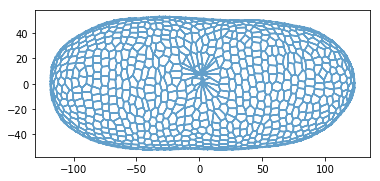

In [62]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/20190827-QSSolver-Prepolarized')
dirname = SIM_DIR/'1.08_constriction_0_radialtension0/'
from tyssue.draw import sheet_view

import ipyvolume.pylab as p3
hfs = [f  for f in os.listdir(dirname)
       if f.endswith('hf5')]
hfs.sort(key=lambda x: os.path.getctime(os.path.join(dirname, x)))

current = 'invagination_0027.hf5'
ipv.clear()
ipv.style.use('dark')


dsets = hdf5.load_datasets(os.path.join(dirname, current),
                               data_names=['vert', 'edge', 'face', 'cell'])

specs = config.geometry.cylindrical_sheet()
sheet = Sheet('ellipse', dsets, specs)
sheet.face_df['test']=0
index =sheet.face_df[(sheet.face_df.z>6) & (sheet.face_df.z<15) 
              & (sheet.face_df.y>25) & (sheet.face_df.y<35) 
                    & (sheet.face_df.x>0)].index
sheet.face_df.loc[index, 'test']=1

#sheet = sheet.extract_bounding_box(z_boundary=[-200,50])
def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color': sheet.vert_df.y,
            #'colormap': 'Reds'
        },
        'face': {
            'visible': True,
            'color': sheet.face_df.area,
            'colormap': 'Blues'
        },
        'vert':{
            'visible':True,
            's':100,
            'alpha': 0.3,
            'zorder': 2,
            'color': sheet.vert_df.radial_tension
            
        }
        
    }
    return specs

"""ipv.clear()
ipv_fig, meshes = sheet_view(sheet, coords=list('zxy'),
                             mode='3D', **draw_specs(sheet))
ipv_fig"""

sheet=sheet.extract_bounding_box(x_boundary=(-150,0))
fig, ax = quick_edge_draw(sheet, ['z', 'y'],
                              alpha=0.7)
sheet.vert_df.radial_tension.unique()

In [115]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/20190827-QSSolver-Prepolarized')
dirname = SIM_DIR/'1.08_constriction_0_radialtension0/'



hfs = [f  for f in os.listdir(dirname) if f.endswith('hf5')]
hfs.sort()


    

def get_meshes(dirname, hdf_file):
    print(hdf_file)
    dsets = hdf5.load_datasets(os.path.join(dirname, hdf_file),
                               data_names=['vert', 'edge', 'face'])
        
    sheet = Sheet('ellipse', dsets)
    geom.update_all(sheet)
    sheet = sheet.extract_bounding_box( z_boundary=(-80,80))
    #x_boundary=(-50,150),
    print(sheet.vert_df.radial_tension.unique())
    
    import matplotlib
    cmap = matplotlib.colors.ListedColormap(['black', 'red', ]) 
    

    faces = face_mesh(sheet, coords=['x', 'y', 'z'],
                     color=sheet.face_df['apoptosis'],
                     colormap='viridis', 
                     )
    

    sheet.edge_df['color']=0    
    cmap_edge = matplotlib.colors.ListedColormap(['white', 'deeppink'])

    edges = edge_mesh(sheet, coords=['x', 'y', 'z'],
                  color = sheet.edge_df.color,
                  color_range=(0,1),
                  colormap=cmap_edge)
    return faces, edges

from ipywidgets import interact

def browse_sheets(dirname, hfs):
    n = len(hfs)
    ipv.clear()
    fig = ipv.gcf()
    meshes = get_meshes(dirname, hfs[0])
    fig.meshes = fig.meshes + list(meshes)
    
    def view_sheet(i):
        fig.animation = 0
        faces, edges = get_meshes(dirname, hfs[i])
        print()
        fig.meshes[0].x = faces.x
        fig.meshes[0].y = faces.y
        fig.meshes[0].z = faces.z
        fig.meshes[0].color = faces.color
        fig.meshes[0].triangles = faces.triangles

        fig.meshes[1].x = edges.x
        fig.meshes[1].y = edges.y
        fig.meshes[1].z = edges.z
        fig.meshes[1].color = edges.color
        fig.meshes[1].lines = edges.lines

        lim_inf = sheet.vert_df[sheet.coords].min().min()
        lim_sup = sheet.vert_df[sheet.coords].max().max()
        ipv.xyzlim(lim_inf, lim_sup)
    ipv.show()
    interact(view_sheet, i=(0, n-1))
    
browse_sheets(dirname, hfs)

invagination_0000.hf5
[0]


interactive(children=(IntSlider(value=24, description='i', max=48), Output()), _dom_classes=('widget-interact'…

In [113]:
def open_sheet(dirname, t, data_names=['vert', 'edge', 'face', 'cell']):
    """Open hdf5 file

    Open HDF5 file correspond to t time from dirname directory.

    Parameters
    ----------
    directory : str
        complete directory path
    t : int
        time step
    """
    file_name = 'invagination_{:04d}.hf5'.format(t)
    dsets = hdf5.load_datasets(os.path.join(dirname, file_name),
                               data_names=data_names)

    specs = config.geometry.cylindrical_sheet()
    sheet = Sheet('ellipse', dsets, specs)
    return sheet


sheet = open_sheet(dirname,0)

area = []
line_tension=[]
for t in range(0, 200):
    try:
        id_ = 146
        sheet = open_sheet(dirname,t)
        area.append(sheet.face_df[sheet.face_df.id == id_].area.values[0])
        index = sheet.face_df[sheet.face_df.id == id_].index.values[0]
        line_tension.append(sheet.edge_df[sheet.edge_df.face == index].line_tension.unique())
    except Exception:
        pass



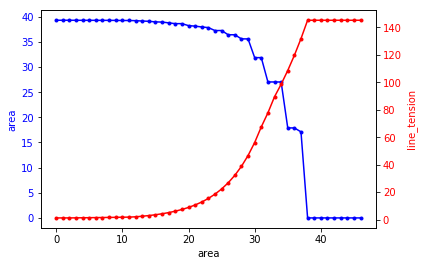

In [114]:
fig, ax1 = plt.subplots()
t = np.arange(0.01, 10.0, 0.01)
s1 = np.exp(t)
ax1.plot(area, 'b.-')
ax1.set_xlabel('area')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('area', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()
s2 = np.sin(2*np.pi*t)
ax2.plot(line_tension,  'r.-')
ax2.set_ylabel('line_tension', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.savefig('ShareAxes.png')    
plt.show()

In [108]:
sheet.face_df[sheet.face_df.apoptosis==2]

,x,y,z,num_sides,area,perimeter,is_alive,face_o,opposite,height,rho,vol,phi,theta,area_elasticity,prefered_area,contractility,id,fold,apoptosis
face,,,,,,,,,,,,,,,,,,,,
3,14.330052,48.747351,2.106972,6,9.592107e-07,0.004899,1.0,3.0,-1.0,46.853652,50.853652,0.000045,1.298173,-0.035314,1.0,48.099945,1.52,3,1,2
4,-16.319035,46.853419,1.151145,6,2.084085e-06,0.009185,1.0,4.0,-1.0,45.627401,49.627401,0.000095,1.545096,0.032793,1.0,34.586170,1.52,4,1,2
146,-33.937564,-35.166118,-1.752884,6,1.430488e-06,0.008142,1.0,146.0,-1.0,44.902829,48.902829,0.000064,-1.979784,-0.035320,1.0,39.248328,1.52,146,1,2
175,18.571765,-47.687346,-3.312977,6,3.918530e+01,23.992173,1.0,175.0,-1.0,47.446697,51.446697,1859.477059,-1.161809,0.032846,1.0,39.003581,1.52,175,1,2
349,-37.531921,27.325211,1.199814,6,5.463162e+01,38.355155,1.0,349.0,-1.0,43.061407,47.061407,2349.737649,2.116206,-0.035329,1.0,53.417270,1.52,349,1,2
502,-47.678153,4.781549,1.041196,6,2.075507e-06,0.012461,1.0,72.0,-1.0,43.928630,47.928630,0.000091,2.662645,0.100854,1.0,38.001339,1.52,502,1,2
541,-18.026062,46.540277,-3.169154,6,2.796819e+01,21.965044,1.0,4.0,-1.0,46.166194,50.166194,1292.572293,1.545096,0.032793,1.0,36.404171,1.52,541,1,2
612,-20.055527,44.843531,4.423563,6,4.031483e+01,26.076935,1.0,5.0,-1.0,45.543626,49.543626,1846.088379,1.822596,0.032789,1.0,50.113737,1.52,612,1,2
658,13.902396,49.178403,-1.705509,6,2.854464e+01,22.960159,1.0,194.0,-1.0,47.314249,51.314249,1358.736367,1.025387,-0.103193,1.0,38.357615,1.52,658,1,2
